In [ ]:
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from sklearn.linear_model import RidgeCV

In [ ]:
%run forecasting.ipynb


## Инициализируем гидропосты, находящиеся вдоль русла реки, следующие один за другим 

In [ ]:
p_03010=post_model(loc_id=3010, high_of_measurement=281 )
p_03010.station_info

station_id       station_name    lat   lon  \
0      3010.0  УСТЬ-КУТ - Р.ЛЕНА  105.8  56.8   

                                                geom  
0  0101000020E61000003333333333735A40666666666666...

In [ ]:
p_03012=post_model(loc_id=3012, high_of_measurement=281 )
p_03012.station_info


station_id         station_name     lat    lon  \
0      3012.0  ПОДЫМАХИНО - Р.ЛЕНА  106.18  56.98   

                                                geom  
0  0101000020E6100000EC51B81E858B5A403D0AD7A3707D...

In [ ]:
p_03015=post_model(loc_id=3015, high_of_measurement=267)
p_03015.station_info

station_id      station_name     lat    lon  \
0      3015.0  МАРКОВО - Р.ЛЕНА  107.06  57.33   

                                                geom  
0  0101000020E6100000A4703D0AD7C35A400AD7A3703DAA...

In [ ]:
p_03019=post_model(loc_id=3019, high_of_measurement=249)
p_03019.station_info

station_id      station_name     lat    lon  \
0      3019.0  КИРЕНСК - Р.ЛЕНА  108.07  57.77   

                                                geom  
0  0101000020E610000014AE47E17A045B40C3F5285C8FE2...

## Добавим к данным гидропостов метеопараметры 

In [ ]:
p_03010.add_snowdata(n_nearest=40, addlags=40, add_count=2)
p_03012.add_snowdata(n_nearest=40, addlags=40, add_count=2)
p_03015.add_snowdata(n_nearest=40, addlags=40, add_count=2)
p_03019.add_snowdata(n_nearest=40, addlags=40, add_count=2)
p_03010.add_weather_data(n_nearest=30)
p_03012.add_weather_data(n_nearest=30)
p_03015.add_weather_data(n_nearest=30)
p_03019.add_weather_data(n_nearest=30)



## Выполним предобработку данных по простому алгоритму 

In [ ]:
p_03010.make_simple_formation()
p_03012.make_simple_formation()
p_03015.make_simple_formation()
p_03019.make_simple_formation()


## Перенесем признаки максимального уровня воды нижестоящего гидропоста на вышестоящие

In [ ]:

p_03015.hydroframe['max_level_p_03010']=p_03010.hydroframe['max_level']
p_03019.hydroframe['max_level_p_03010']=p_03010.hydroframe['max_level']
p_03015.hydroframe['was_na_p_03010']=p_03010.hydroframe['was_na']
p_03019.hydroframe['was_na_p_03010']=p_03010.hydroframe['was_na']
p_03015.hydroframe['will_na_p_03010']=p_03010.hydroframe['will_na']
p_03019.hydroframe['will_na_p_03010']=p_03010.hydroframe['will_na']
p_03019.hydroframe=p_03019.hydroframe.loc[~p_03019.hydroframe['max_level_p_03010'].isna()]

p_03010.hydroframe=p_03010.hydroframe.iloc[1:]
p_03012.hydroframe=p_03012.hydroframe.iloc[1:]
p_03015.hydroframe=p_03015.hydroframe.iloc[1:]
p_03019.hydroframe=p_03019.hydroframe.iloc[1:]


In [ ]:
p_03019.hydroframe=p_03019.hydroframe_clean

## Разложим признаки на нескореллированные
 

In [ ]:
from sklearn.decomposition import KernelPCA

pca = KernelPCA(n_components =18, kernel='rbf' )
p_03019.hydroframe_clean=p_03019.hydroframe.copy()
p_03019.hydroframe = pca.fit_transform(p_03019.hydroframe_clean)
p_03019.hydroframe=pd.DataFrame(p_03019.hydroframe)
p_03019.hydroframe.index=p_03019.hydroframe_clean.index
p_03019.hydroframe=pd.concat([p_03019.hydroframe_clean['max_level'],p_03019.hydroframe],axis=1)


## Сформируем выборки для обучения нейросети 

In [ ]:
p_03019.make_trains(column_to_predict='max_level', split_date='2013-01-01', split_date_2='2018-01-01')

## Обучим нейросеть и XGB-  модели

In [ ]:
p_03019.make_LSTM2_model(cuted=False, lr=0.001, lag=14, LSTM_units=100, batch_size=400, dense_small=200, dense_small1=20) #batch_size=852

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 14, 19)]     0                                            
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 100)          48000       input_4[0][0]                    
__________________________________________________________________________________________________
dense_63 (Dense)                (None, 200)          20200       lstm_3[0][0]                     
__________________________________________________________________________________________________
dense_64 (Dense)                (None, 200)          20200       lstm_3[0][0]                     
____________________________________________________________________________________________

In [ ]:
p_03019.make_week_XGB_stack( cut_months=False, column_to_predict='max_level', split_date='2014-01-01', n_estimators=1000, max_depth=6, eta=0.1372, subsample=0.9521413041539605, colsample_bytree=1.0, colsample_bylevel=0.72291, min_child_weight= 0.24052, reg_lambda=0.03559, alpha=0.61582, gamma=0)

## Cформируем фрейм предсказаний моделей, на котором будем обучать ансамблирующие алгоритмы

In [ ]:
p_03019.make_stackframe(dateinterval={'start':'2013-01-01','end':'2018-01-01'}, LSTM_lag=14)



## Обучим ансамблирующие алгоритмы на полученном фрейме, предварительно разложив его на нескорреллированные метапризнаки тем же kernel PCA

In [ ]:

p_03019.make_stackmodel(column_to_predict='max_level', model='ridge')


## Визуализируем результат обучения на валидационной выборке

In [ ]:
bigframe=pd.DataFrame()
for day in pd.date_range(start='2018-01-01', end='2021-11-07').date:
    try:
        frame=p_03019.make_stack_prediction(actual_date=str(day), LSTM_lag=14)
        frame['day']=range(1,8)
        bigframe=bigframe.append(frame, ignore_index=True)
    except TypeError:
        continue

In [ ]:
XGB_MAE, LSTM_MAE, ensamble_MAE = np.array([]),np.array([]),np.array([])
XGB_MAE50, LSTM_MAE50, ensamble_MAE50= np.array([]),np.array([]),np.array([])
XGB_MSE, LSTM_MSE, ensamble_MSE=np.array([]),np.array([]),np.array([])

for day in range(1,8):
    XGB_MAE=np.append(XGB_MAE, np.abs(bigframe.loc[bigframe.day==day]['measured']-bigframe.loc[bigframe.day==day]['XGB']).mean())
    LSTM_MAE=np.append(LSTM_MAE, np.abs(bigframe.loc[bigframe.day==day]['measured']-bigframe.loc[bigframe.day==day]['LSTM']).mean())
    ensamble_MAE=np.append(ensamble_MAE, np.abs(bigframe.loc[bigframe.day==day]['measured']-bigframe.loc[bigframe.day==day]['stack_pred']).mean())
    
    XGB_MAE50=np.append(XGB_MAE50, (np.abs((bigframe.loc[bigframe.day==day]['measured']-bigframe.loc[bigframe.day==day]['XGB'])).sort_values(na_position='first')[-50:]).mean())
    LSTM_MAE50=np.append(LSTM_MAE50, (np.abs((bigframe.loc[bigframe.day==day]['measured']-bigframe.loc[bigframe.day==day]['LSTM'])).sort_values(na_position='first')[-50:]).mean())
    ensamble_MAE50=np.append(ensamble_MAE50, (np.abs((bigframe.loc[bigframe.day==day]['measured']-bigframe.loc[bigframe.day==day]['stack_pred'])).sort_values(na_position='first')[-50:]).mean())
    
    XGB_MSE=np.append(XGB_MSE, ((bigframe.loc[bigframe.day==day]['measured']-bigframe.loc[bigframe.day==day]['XGB'])**2).mean())
    LSTM_MSE=np.append(LSTM_MSE, ((bigframe.loc[bigframe.day==day]['measured']-bigframe.loc[bigframe.day==day]['LSTM'])**2).mean())
    ensamble_MSE=np.append(ensamble_MSE, ((bigframe.loc[bigframe.day==day]['measured']-bigframe.loc[bigframe.day==day]['stack_pred'])**2).mean())


errors=pd.DataFrame()
errors['XGB_MAE']=XGB_MAE
errors['XGB_MAE50']=XGB_MAE50
errors['XGB_MSE']=XGB_MSE
errors['LSTM_MAE']=LSTM_MAE
errors['LSTM_MAE50']=LSTM_MAE50
errors['LSTM_MSE']=LSTM_MSE
errors['ensamble_MAE']=ensamble_MAE
errors['ensamble_MAE50']=ensamble_MAE50
errors['ensamble_MSE']=ensamble_MSE

## Cреднеабсолютная ошибка по дням

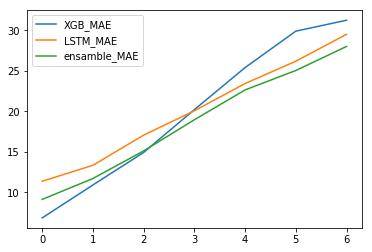

In [ ]:
_=errors[['XGB_MAE', 'LSTM_MAE', 'ensamble_MAE']].plot()

## Среднее 50 самых больших среднеабсолютных ошибок по дням 

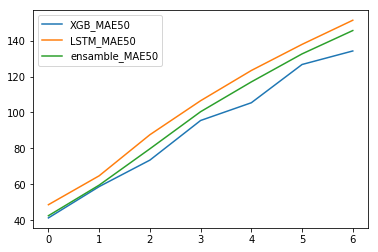

In [ ]:
_=errors[['XGB_MAE50', 'LSTM_MAE50', 'ensamble_MAE50']].plot()

## Среднеквадратическая ошибка по дням

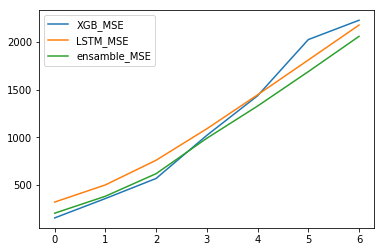

In [ ]:
_=errors[['XGB_MSE', 'LSTM_MSE', 'ensamble_MSE']].plot()

In [ ]:
errors

XGB_MAE   XGB_MAE50      XGB_MSE   LSTM_MAE  LSTM_MAE50     LSTM_MSE  \
0   6.822631   41.266436   155.122369  11.955254   53.365807   321.374635   
1  10.893054   58.708270   358.480866  14.043479   66.270671   501.413737   
2  14.910278   73.461457   569.299865  16.705743   86.528336   760.720654   
3  20.202614   95.549556  1021.767739  20.009444  104.081819  1090.468173   
4  25.402541  105.431973  1436.952696  23.505062  118.504882  1446.782403   
5  29.903383  126.747098  2026.259794  25.771206  134.435749  1811.889305   
6  31.254043  134.280016  2229.228350  28.457263  146.668336  2178.820896   

   ensamble_MAE  ensamble_MAE50  ensamble_MSE  
0      9.113842       44.426786    204.635036  
1     11.741065       58.431338    382.552173  
2     14.842749       79.211089    619.667903  
3     18.906241       98.727740    991.322311  
4     22.580627      113.068432   1328.977495  
5     24.963637      129.794870   1690.133720  
6     27.570404      142.599901   2060.114731

## Сравнительные графики предсказаний моделей по дням

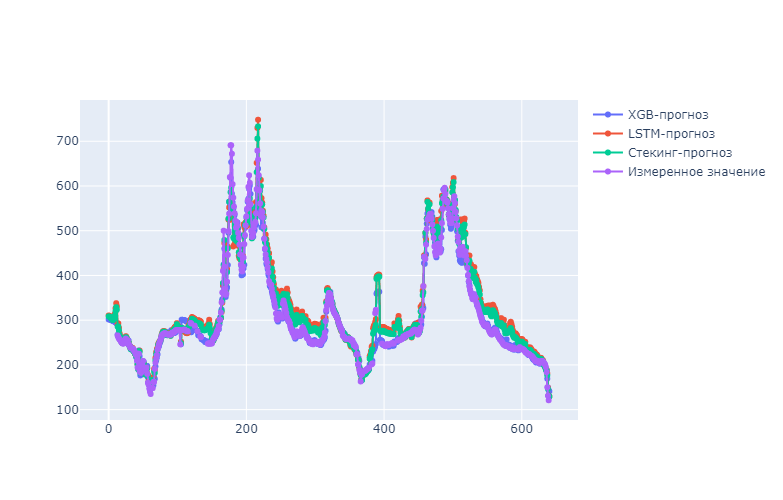

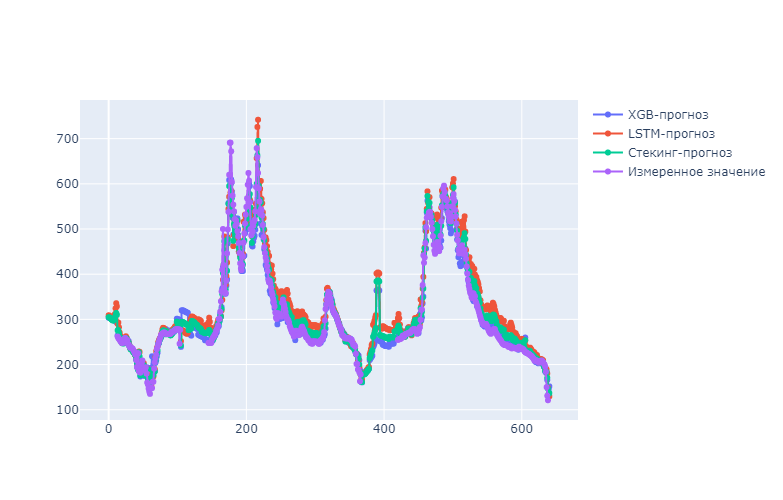

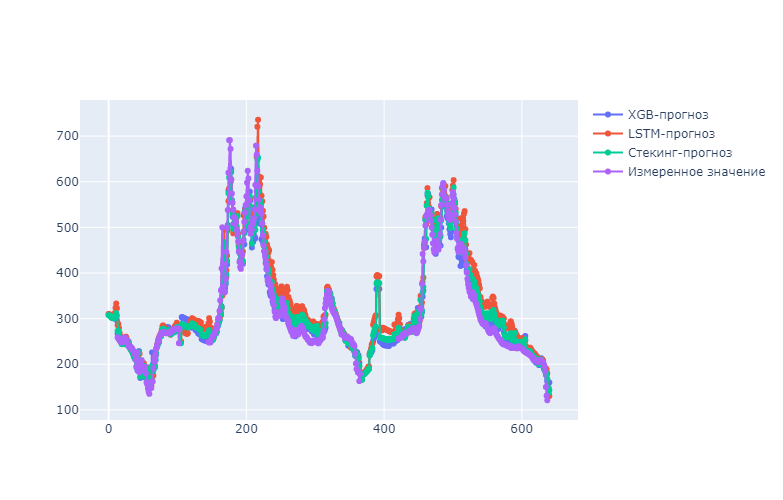

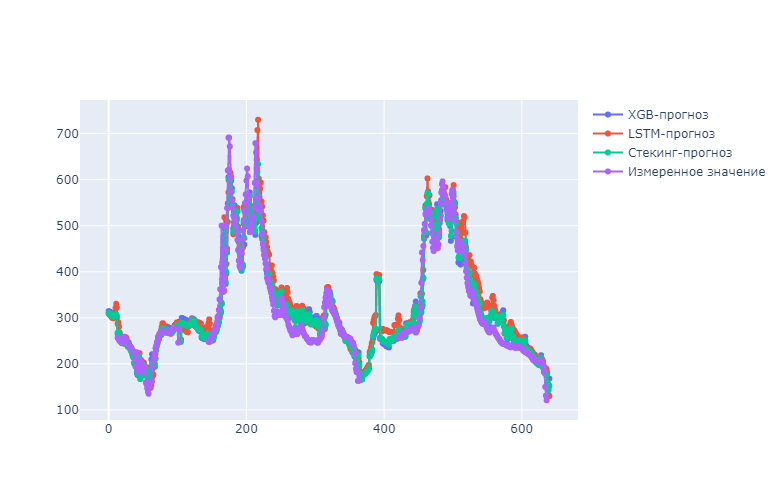

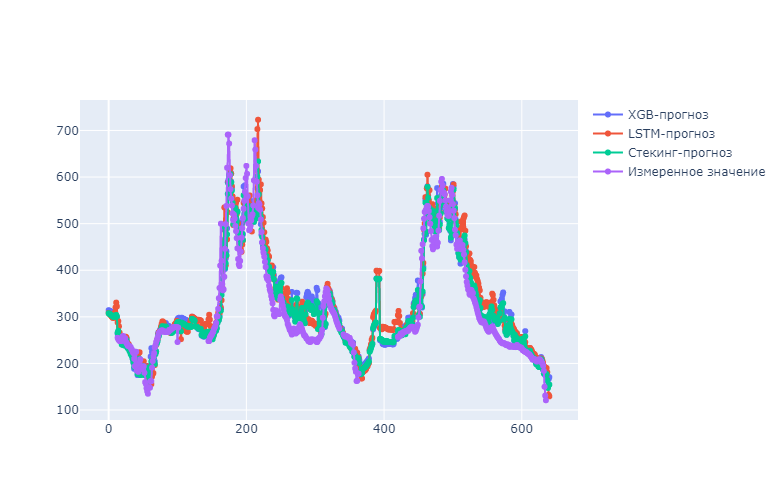

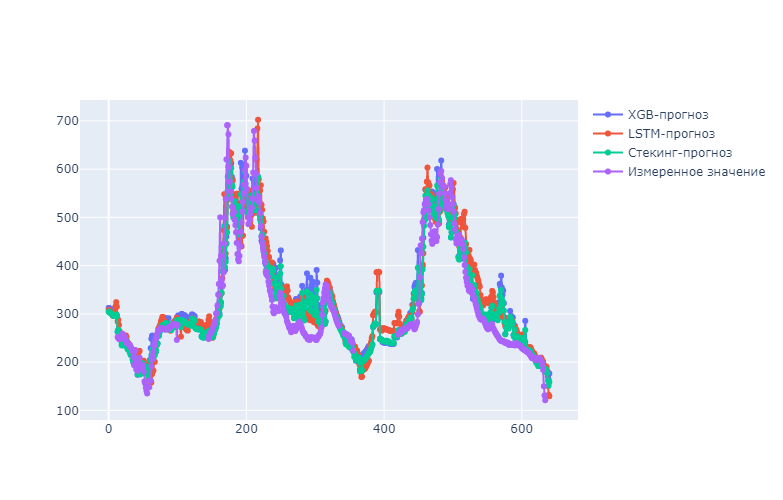

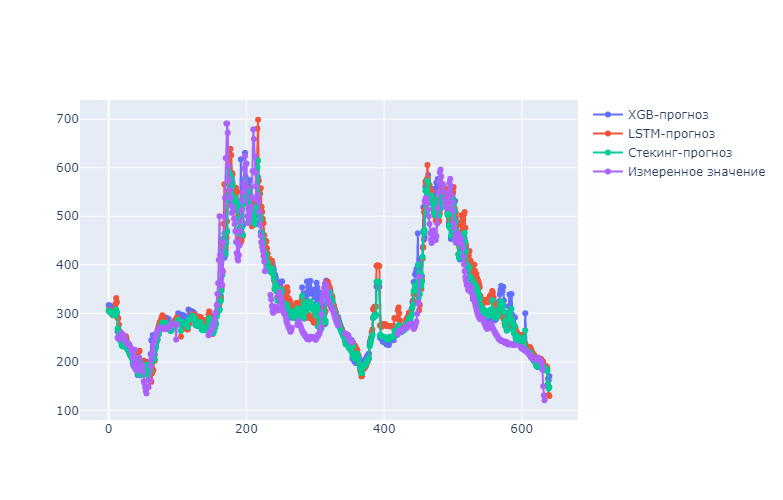

In [ ]:
for day  in range(1,8):
    frame=bigframe.loc[bigframe.day==day].reset_index(drop=True)
    fig = go.Figure()
    fig.add_trace(go.Scatter( y=frame['XGB'], x=frame.index,  mode='lines+markers',  name='XGB-прогноз'))
    fig.add_trace(go.Scatter( y=frame['LSTM'], x=frame.index, mode='lines+markers',  name='LSTM-прогноз'))
    fig.add_trace(go.Scatter( y=frame['stack_pred'], x=frame.index, mode='lines+markers',  name='Стекинг-прогноз'))
    fig.add_trace(go.Scatter( y=frame['measured'], x=frame.index, mode='lines+markers',  name='Измеренное значение'))
    fig.update_layout(
    autosize=False,
    width=1000,
    height=500,)
    fig.show()

## Готовы давать прогноз на будущее

In [ ]:
p_03019.make_stack_prediction(actual_date=str(p_03019.hydroframe.index[-1])[:-9], LSTM_lag=14)

XGB        LSTM  measured  stack_pred
2021-11-05  163.962516  179.345065       NaN  175.776241
2021-11-06  157.364048  179.365856       NaN  167.147318
2021-11-07  154.242344  178.897831       NaN  162.545101
2021-11-08  162.001538  179.526681       NaN  167.338026
2021-11-09  166.482574  180.414311       NaN  168.176689
2021-11-10  168.105781  179.983259       NaN  168.993161
2021-11-11  192.480493  181.158386       NaN  183.373081